In [ ]:
import torch
import torchvision
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hyperparameters
val_split = 0.1
lr = 0.0005
batch_size = 64
num_epochs = 10

# Datasets
transform_mnist = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])
transform_cifar = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)

# Validation split
def split_data(dataset, val_split=0.1):
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
    return train_set, val_set

mnist_train_set, mnist_val_set = split_data(mnist_train)
cifar_train_set, cifar_val_set = split_data(cifar_train)

# DataLoader
def get_loader(dataset, batch_size, shuffle=True):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

mnist_val_loader = get_loader(mnist_val_set, batch_size=1024, shuffle=False)
cifar_val_loader = get_loader(cifar_val_set, batch_size=1024, shuffle=False)

# Model Setup
def get_model(dataset_name):
    if dataset_name == 'mnist':
        model = torchvision.models.resnet18(pretrained=False)
        model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        model.fc = torch.nn.Linear(model.fc.in_features, 10)
    elif dataset_name == 'cifar':
        model = torchvision.models.resnet18(pretrained=False)
        model.fc = torch.nn.Linear(model.fc.in_features, 10)
    return model

# Training and Validation
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Experiment for Data Scaling
def data_scaling_experiment(train_dataset, val_loader, dataset_name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if device.type == 'cuda':
        torch.cuda.set_per_process_memory_fraction(0.8)
    data_sizes = [0.01, 0.05, 0.1, 0.22]
    accuracies = []

    for size in data_sizes:
        subset_size = int(size * len(train_dataset))
        train_subset, _ = torch.utils.data.random_split(train_dataset, [subset_size, len(train_dataset) - subset_size])
        train_loader = get_loader(train_subset, batch_size=batch_size)

        model = get_model(dataset_name)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        print(f"Training with {subset_size} data points...")
        accuracy = train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs)
        accuracies.append(accuracy)

    return data_sizes, accuracies

# Run Experiments
mnist_sizes, mnist_accuracies = data_scaling_experiment(mnist_train_set, mnist_val_loader, 'mnist')
cifar_sizes, cifar_accuracies = data_scaling_experiment(cifar_train_set, cifar_val_loader, 'cifar')

#%%
# Plot Results
plt.figure(figsize=(10, 6))
plt.plot([s * len(mnist_train_set) for s in mnist_sizes], mnist_accuracies, label='MNIST')
plt.plot([s * len(cifar_train_set) for s in cifar_sizes], cifar_accuracies, label='CIFAR-10')
plt.xlabel('Number of Labeled Data Points', fontsize=15)
plt.ylabel('Validation Accuracy (%)', fontsize=15)
plt.title('Accuracy vs. Labeled Data Points')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.legend()
plt.grid()
plt.show()


Files already downloaded and verified
Training with 540 data points...
Training with 2700 data points...
Training with 5400 data points...
Training with 11880 data points...
Training with 450 data points...
Training with 2250 data points...
Training with 4500 data points...
Training with 9900 data points...


In [2]:
import torch
print(torch.cuda.is_available())  # Returns True if GPU is available
print(torch.cuda.get_device_name(0))  # Prints the name of the GPU if available

True
NVIDIA GeForce RTX 2080 SUPER


In [3]:
import torch
import torchvision
import numpy as np
from copy import deepcopy
import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys

if __name__ == "__main__" and "ipykernel" not in sys.argv[0]:
    ap = argparse.ArgumentParser()
    ap.add_argument("-d", "--debug", action='store_true', help="Debug mode")
    args = ap.parse_args()
else:
    # Default argument handling for Jupyter
    class Args:
        debug = False
    args = Args()
    
### Hyperparameters
val_split = 0.1
unlabelled_size = 0.99
lr = 0.0005
batch_size = 64
num_epochs = 100
label_iterations = 20
top_frac = 0.05

### Setup MNIST dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

debug = args.debug
if debug:
    train_dataset.data = train_dataset.data[:1000]
    train_dataset.targets = train_dataset.targets[:1000]
    
    torch.set_num_threads(4)
val_dataset = deepcopy(train_dataset)

train_size = int((1 - val_split) * len(train_dataset))
val_size = len(train_dataset) - train_size
indexes = torch.randperm(len(train_dataset)).tolist()
# Define validation set
indexes_val = indexes[train_size:]
val_dataset.targets = val_dataset.targets[indexes_val]
val_dataset.data = val_dataset.data[indexes_val]
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)

# Define training set
indexes_train = indexes[:train_size]
train_dataset.targets = train_dataset.targets[indexes_train]
train_dataset.data = train_dataset.data[indexes_train]

# Split training data into labelled and unlabelled
unlabelled_size = int(unlabelled_size * len(train_dataset))
indexes_train = torch.randperm(len(train_dataset)).tolist()  # Redefine indexes_train
unlabbelled_dataset = deepcopy(train_dataset)
unlabbelled_dataset.targets = unlabbelled_dataset.targets[indexes_train[:unlabelled_size]]
unlabbelled_dataset.data = unlabbelled_dataset.data[indexes_train[:unlabelled_size]]
train_dataset.targets = train_dataset.targets[indexes_train[unlabelled_size:]]
train_dataset.data = train_dataset.data[indexes_train[unlabelled_size:]]
unlabbelled_dataset.targets = unlabbelled_dataset.targets
unlabbelled_dataset.data = unlabbelled_dataset.data
start_train_dataset = deepcopy(train_dataset)  # Save for baseline
start_unlabbelled_dataset = deepcopy(unlabbelled_dataset)  # Save for baseline


def transfer_unlabelled_to_labeled(unlabbelled_dataset, train_dataset, indexes):
    # Convert indexes to boolean mask
    indexes = torch.tensor([i in indexes for i in range(len(unlabbelled_dataset.targets))])
    
    train_dataset.targets = torch.cat([train_dataset.targets, unlabbelled_dataset.targets[indexes]])
    train_dataset.data = torch.cat([train_dataset.data, unlabbelled_dataset.data[indexes]])
    unlabbelled_dataset.targets = unlabbelled_dataset.targets[~indexes]
    unlabbelled_dataset.data = unlabbelled_dataset.data[~indexes]

    return train_dataset, unlabbelled_dataset

def validate_model(model, val_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Setup model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 10)
# Modify input layer to accept 1 channel
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

model_parameters = deepcopy(model.state_dict())
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, val_interval=1):
    accuracies = []
    for epoch in tqdm(range(num_epochs)):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        if (epoch + 1) % val_interval == 0:
            val_accuracy = validate_model(model, val_loader, device)
            accuracies.append(val_accuracy)
            print(f'Epoch {epoch + 1}, Accuracy: {val_accuracy:.2f}%')
    return accuracies


def label_iteration(model, train_dataset, unlabelled_dataset, device, top_frac=0.01):
    # Use model to label all images in validation set
    model.eval()
    predictions = []
    unlabelled_loader = torch.utils.data.DataLoader(unlabelled_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    with torch.no_grad():
        for images, _ in tqdm(unlabelled_loader):
            images = images.to(device)
            outputs = model(images).softmax(dim=1)
            predictions.extend(outputs.detach().cpu().numpy())

    predictions = torch.tensor(predictions)
    # Find top % of images with lowest top-confidence
    top_percent = int(top_frac * len(predictions))
    _, top_indices = predictions.max(-1)[0].topk(top_percent, largest=False)
    print(f"Adding {len(top_indices)} images to training set")
    train_dataset, unlabelled_dataset = transfer_unlabelled_to_labeled(unlabelled_dataset, train_dataset, top_indices)
    
    return train_dataset, unlabelled_dataset


## Run active learning
datapoint_list = []
accuracy_list = []

max_data_points =10000

for i in range(label_iterations):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    model.load_state_dict(model_parameters)  # Reset the model each iteration
    accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)
    datapoint_list.append(len(train_dataset))
    accuracy_list.append(accuracies)

    # Stop if the labeled dataset reaches the maximum size
    if len(train_dataset) >= max_data_points:
        print(f"Reached {max_data_points} labeled data points. Stopping active learning.")
        break

    # Add new labeled data using active learning
    if i < label_iterations - 1:
        train_dataset, unlabbelled_dataset = label_iteration(model, train_dataset, unlabbelled_dataset, device, top_frac=top_frac)
    
# Add baseline accuracy (no active learning)
n_datapoints = len(train_dataset) - len(start_train_dataset)
model.load_state_dict(model_parameters)
# We reuse the initial training set to reduce run to run variance
train_dataset.data = torch.cat([start_train_dataset.data, start_unlabbelled_dataset.data[:n_datapoints]])
train_dataset.targets = torch.cat([start_train_dataset.targets, start_unlabbelled_dataset.targets[:n_datapoints]])

# Train model
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)
baseline_accuracy = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, val_interval=10)

#%%
def get_dat(datapoints, accuracies):
    datapoints = np.array(datapoint_list)
    accuracies = np.array(accuracy_list).max(-1)  # Max accuracy for each iteration

    # Return the processed arrays
    return datapoints, accuracies


# Plot the accuracy
datapoints = np.array(datapoint_list)
accuracies = np.array(accuracy_list).max(-1)
plt.figure(figsize=(10, 5))
plt.plot(datapoints, accuracies, label='AL Accuracy')
plt.hlines(max(baseline_accuracy), min(datapoints), max(datapoints), label='Baseline Accuracy', color='red')
plt.xlabel('Datapoints')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('figs/accuracy.png')
plt.show()

D:\Python\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Python\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
 11%|█         | 11/100 [00:02<00:34,  2.60it/s]

Epoch 10, Accuracy: 88.92%


 21%|██        | 21/100 [00:05<00:29,  2.64it/s]

Epoch 20, Accuracy: 89.73%


 31%|███       | 31/100 [00:08<00:25,  2.66it/s]

Epoch 30, Accuracy: 89.87%


 41%|████      | 41/100 [00:10<00:22,  2.66it/s]

Epoch 40, Accuracy: 89.88%


 51%|█████     | 51/100 [00:13<00:18,  2.67it/s]

Epoch 50, Accuracy: 89.98%


 61%|██████    | 61/100 [00:15<00:14,  2.67it/s]

Epoch 60, Accuracy: 90.12%


 71%|███████   | 71/100 [00:18<00:10,  2.66it/s]

Epoch 70, Accuracy: 90.12%


 81%|████████  | 81/100 [00:20<00:07,  2.65it/s]

Epoch 80, Accuracy: 90.28%


 91%|█████████ | 91/100 [00:23<00:03,  2.67it/s]

Epoch 90, Accuracy: 90.15%


  1%|          | 7/836 [00:00<00:11, 69.47it/s]

Epoch 100, Accuracy: 90.12%


100%|██████████| 836/836 [00:12<00:00, 69.58it/s]
<ipython-input-3-84e47a20a3f5>:139: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  predictions = torch.tensor(predictions)


Adding 2673 images to training set


 10%|█         | 10/100 [00:10<01:58,  1.32s/it]

Epoch 10, Accuracy: 97.85%


 20%|██        | 20/100 [00:21<01:41,  1.26s/it]

Epoch 20, Accuracy: 97.48%


 30%|███       | 30/100 [00:31<01:28,  1.26s/it]

Epoch 30, Accuracy: 97.70%


 40%|████      | 40/100 [00:42<01:15,  1.25s/it]

Epoch 40, Accuracy: 97.32%


 50%|█████     | 50/100 [00:52<01:02,  1.25s/it]

Epoch 50, Accuracy: 97.82%


 60%|██████    | 60/100 [01:02<00:49,  1.25s/it]

Epoch 60, Accuracy: 98.38%


 70%|███████   | 70/100 [01:13<00:37,  1.25s/it]

Epoch 70, Accuracy: 98.48%


 80%|████████  | 80/100 [01:23<00:25,  1.26s/it]

Epoch 80, Accuracy: 98.35%


 90%|█████████ | 90/100 [01:34<00:12,  1.25s/it]

Epoch 90, Accuracy: 98.48%


  1%|          | 8/794 [00:00<00:10, 71.62it/s]

Epoch 100, Accuracy: 96.90%


100%|██████████| 794/794 [00:11<00:00, 72.03it/s]


Adding 2539 images to training set


 10%|█         | 10/100 [00:17<02:58,  1.98s/it]

Epoch 10, Accuracy: 98.57%


 20%|██        | 20/100 [00:35<02:40,  2.01s/it]

Epoch 20, Accuracy: 98.90%


 30%|███       | 30/100 [00:53<02:18,  1.98s/it]

Epoch 30, Accuracy: 98.53%


 40%|████      | 40/100 [01:10<01:59,  2.00s/it]

Epoch 40, Accuracy: 99.02%


 50%|█████     | 50/100 [01:28<01:39,  1.99s/it]

Epoch 50, Accuracy: 98.58%


 60%|██████    | 60/100 [01:46<01:19,  1.98s/it]

Epoch 60, Accuracy: 98.97%


 70%|███████   | 70/100 [02:04<00:59,  1.98s/it]

Epoch 70, Accuracy: 99.00%


 80%|████████  | 80/100 [02:21<00:40,  2.01s/it]

Epoch 80, Accuracy: 99.00%


 90%|█████████ | 90/100 [02:39<00:20,  2.00s/it]

Epoch 90, Accuracy: 98.53%


  1%|          | 8/754 [00:00<00:10, 71.60it/s]

Epoch 100, Accuracy: 98.70%


100%|██████████| 754/754 [00:10<00:00, 70.99it/s]


Adding 2412 images to training set


 10%|█         | 10/100 [00:25<04:11,  2.79s/it]

Epoch 10, Accuracy: 98.62%


 20%|██        | 20/100 [00:51<03:38,  2.73s/it]

Epoch 20, Accuracy: 98.80%


 24%|██▍       | 24/100 [01:01<03:14,  2.56s/it]


KeyboardInterrupt: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Example Data
# Replace these with actual datapoints and accuracy values
datapoints = np.array(datapoint_list)  # From Active Learning
accuracies = np.array(accuracy_list).max(-1)  # From Active Learning
#baseline_accuracy = max(baseline_accuracy)  # Baseline accuracy
mnist_sizes = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
mnist_accuracies = [85, 90, 93, 94, 95, 96]  # Replace with actual MNIST values
cifar_sizes = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
cifar_accuracies = [50, 55, 60, 65, 70, 75]  # Replace with actual CIFAR-10 values

# Combine Plots
plt.figure(figsize=(8, 8))

# MNIST and CIFAR-10 Accuracy
plt.plot([s * len(mnist_train_set) for s in mnist_sizes], mnist_accuracies, label='MNIST Accuracy', linewidth = 3, color = 'r')
plt.plot([s * len(cifar_train_set) for s in cifar_sizes], cifar_accuracies, label='CIFAR-10 Accuracy', linewidth =3, color = 'b')
plt.plot([s * len(mnist_train_set) for s in mnist_sizes], mnist_accuracies, 'o', color ='firebrick', markersize = 10)
plt.plot([s * len(cifar_train_set) for s in cifar_sizes], cifar_accuracies, 'v', color = 'dodgerblue', markersize = 10)



# Active Learning and Baseline
#plt.plot(datapoints, accuracies, label='MNIST - AL Accuracy', linestyle='--', linewidth = 3, color = 'g')
#plt.hlines(xmin = 500, xmax = 10000, y = 32.39, linestyle='--', linewidth = 3, color = 'y', label ='CIFAR-10 - Baseline accuracy')
#plt.hlines(baseline_accuracy, min(datapoints), 55000, colors='red', linestyles='dotted', label='MNIST - Baseline Accuracy', color = 'k')

#plt.plot(cifar_al_datapoints, cifar_al_accuracies, label='CIFAR-10 AL Accuracy', linestyle='--', color='blue')

# Plot Aesthetics
plt.xlabel('Number of Labeled Data Points', fontsize=17)
plt.ylabel('Validation Accuracy (%)', fontsize=17)
plt.title('Accuracy Comparison Across AL, Baseline, MNIST, and CIFAR-10', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=20)
plt.legend(prop = {'size':12})
plt.grid()
plt.xlim(0, 10000)
plt.ylim(0, 110)

# Save and Show
plt.tight_layout()

plt.show()




NameError: name 'datapoint_list' is not defined

In [38]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 18 14:31:35 2024

@author: vicly
"""

import torch
import torchvision
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm

# Hyperparameters
val_split = 0.1
lr = 0.0005
batch_size = 64
num_epochs = 10
step_size = 1000  # Number of samples added per active learning iteration

# Datasets
transform_mnist = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])
transform_cifar = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)

# Validation split
def split_data(dataset, val_split=0.1):
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])
    return train_set, val_set

mnist_train_set, mnist_val_set = split_data(mnist_train)
cifar_train_set, cifar_val_set = split_data(cifar_train)

# DataLoader
def get_loader(dataset, batch_size, shuffle=True):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

mnist_val_loader = get_loader(mnist_val_set, batch_size=1024, shuffle=False)
cifar_val_loader = get_loader(cifar_val_set, batch_size=1024, shuffle=False)

# Model Setup
def get_model(dataset_name):
    if dataset_name == 'mnist':
        model = torchvision.models.resnet18(pretrained=False)
        model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        model.fc = torch.nn.Linear(model.fc.in_features, 10)
    elif dataset_name == 'cifar':
        model = torchvision.models.resnet18(pretrained=False)
        model.fc = torch.nn.Linear(model.fc.in_features, 10)
    return model

# Training and Validation
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Active Learning Functions
def uncertainty_sampling(model, unlabeled_loader, device, top_n):
    model.eval()
    uncertainties = []
    indices = []

    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(unlabeled_loader):
            images = images.to(device)
            outputs = model(images).softmax(dim=1)
            max_probs, _ = outputs.max(dim=1)
            uncertainty = 1 - max_probs  # Least confidence
            uncertainties.extend(uncertainty.cpu().numpy())
            indices.extend(range(batch_idx * len(images), (batch_idx + 1) * len(images)))

    # Select top N uncertain samples
    uncertainties = np.array(uncertainties)
    top_indices = np.argsort(-uncertainties)[:top_n]
    return np.array(indices)[top_indices]

def margin_sampling(model, unlabeled_loader, device, top_n):
    model.eval()
    margins = []
    indices = []

    with torch.no_grad():
        for batch_idx, (images, _) in enumerate(unlabeled_loader):
            images = images.to(device)
            outputs = model(images).softmax(dim=1)
            top2_probs = torch.topk(outputs, 2, dim=1).values
            margin = top2_probs[:, 0] - top2_probs[:, 1]
            margins.extend(margin.cpu().numpy())
            indices.extend(range(batch_idx * len(images), (batch_idx + 1) * len(images)))

    # Select top N smallest margin samples
    margins = np.array(margins)
    top_indices = np.argsort(margins)[:top_n]
    return np.array(indices)[top_indices]

# Main Active Learning Loop
def active_learning_experiment(initial_size, total_size, dataset, val_loader, dataset_name, strategy='uncertainty', step_size=1000):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initial labeled and unlabeled datasets
    labeled_indices = np.random.choice(len(dataset), initial_size, replace=False)
    unlabeled_indices = np.setdiff1d(np.arange(len(dataset)), labeled_indices)
    labeled_dataset = torch.utils.data.Subset(dataset, labeled_indices)
    unlabeled_dataset = torch.utils.data.Subset(dataset, unlabeled_indices)
    
    labeled_loader = get_loader(labeled_dataset, batch_size=batch_size)
    unlabeled_loader = get_loader(unlabeled_dataset, batch_size=batch_size, shuffle=False)
    
    accuracies = []
    sizes = []

    while len(labeled_dataset) < total_size:
        # Train model on the current labeled set
        model = get_model(dataset_name)
        model.to(device)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        accuracy = train_and_validate(model, labeled_loader, val_loader, criterion, optimizer, device, num_epochs)
        accuracies.append(accuracy)
        sizes.append(len(labeled_dataset))

        print(f"Labeled Data Points: {len(labeled_dataset)}, Accuracy: {accuracy:.2f}%")

        # Exit if we reach the total size
        if len(labeled_dataset) + step_size > total_size:
            break

        # Select new samples
        if strategy == 'uncertainty':
            top_indices = uncertainty_sampling(model, unlabeled_loader, device, step_size)
        elif strategy == 'margin':
            top_indices = margin_sampling(model, unlabeled_loader, device, step_size)

        # Add selected samples to the labeled dataset
        labeled_indices = np.concatenate([labeled_indices, unlabeled_indices[top_indices]])
        unlabeled_indices = np.setdiff1d(unlabeled_indices, unlabeled_indices[top_indices])
        labeled_dataset = torch.utils.data.Subset(dataset, labeled_indices)
        unlabeled_dataset = torch.utils.data.Subset(dataset, unlabeled_indices)

        labeled_loader = get_loader(labeled_dataset, batch_size=batch_size)
        unlabeled_loader = get_loader(unlabeled_dataset, batch_size=batch_size, shuffle=False)

    return sizes, accuracies

# Run Active Learning Experiment
mnist_sizes_uncertainty, mnist_accuracies_uncertainty = active_learning_experiment(
    initial_size=1000, total_size=10000, dataset=mnist_train_set, val_loader=mnist_val_loader, dataset_name='mnist', strategy='uncertainty'
)

mnist_sizes_margin, mnist_accuracies_margin = active_learning_experiment(
    initial_size=1000, total_size=10000, dataset=mnist_train_set, val_loader=mnist_val_loader, dataset_name='mnist', strategy='margin'
)


# Plot Results
plt.figure(figsize=(10, 6))
plt.plot(mnist_sizes_uncertainty, mnist_accuracies_uncertainty, label='Uncertainty Sampling', linewidth = 3)
plt.plot(mnist_sizes_margin, mnist_accuracies_margin, label='Margin Sampling', linewidth = 3)
plt.plot(mnist_sizes_uncertainty, mnist_accuracies_uncertainty, 'v', color = 'dodgerblue', markersize = 10)
plt.plot(mnist_sizes_margin, mnist_accuracies_margin, 'o', color ='darkorange', markersize = 10)
plt.xlabel('Uncertainty Sampling', fontsize = 15)
plt.ylabel("Intensity /a.u.", fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.plot(datapoints, accuracies, label='AL Accuracy')
plt.hlines(max(baseline_accuracy), min(datapoints), max(datapoints), label='Baseline Accuracy', color='red')

plt.title(label = 'Active learning - MNIST', fontsize = 40)
plt.xlabel('Number of Labeled Data Points')
plt.ylabel('Validation Accuracy (%)')
plt.title('Active Learning Strategies - MNIST')
plt.legend(prop = {'size':12})
plt.grid()
plt.show()


Files already downloaded and verified


D:\Python\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Python\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Labeled Data Points: 1000, Accuracy: 93.35%
Labeled Data Points: 2000, Accuracy: 95.77%
Labeled Data Points: 3000, Accuracy: 96.95%
Labeled Data Points: 4000, Accuracy: 97.35%
Labeled Data Points: 5000, Accuracy: 98.35%
Labeled Data Points: 6000, Accuracy: 96.90%
Labeled Data Points: 7000, Accuracy: 98.63%
Labeled Data Points: 8000, Accuracy: 98.33%
Labeled Data Points: 9000, Accuracy: 98.15%
Labeled Data Points: 1000, Accuracy: 86.13%
Labeled Data Points: 2000, Accuracy: 94.27%
Labeled Data Points: 3000, Accuracy: 96.93%
Labeled Data Points: 4000, Accuracy: 97.65%
Labeled Data Points: 5000, Accuracy: 97.47%
Labeled Data Points: 6000, Accuracy: 98.57%
Labeled Data Points: 7000, Accuracy: 97.28%
Labeled Data Points: 8000, Accuracy: 98.70%
Labeled Data Points: 9000, Accuracy: 97.82%


ModuleNotFoundError: No module named 'Baseline_ACC'

Files already downloaded and verified
Files already downloaded and verified


D:\Python\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Python\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Training: 100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


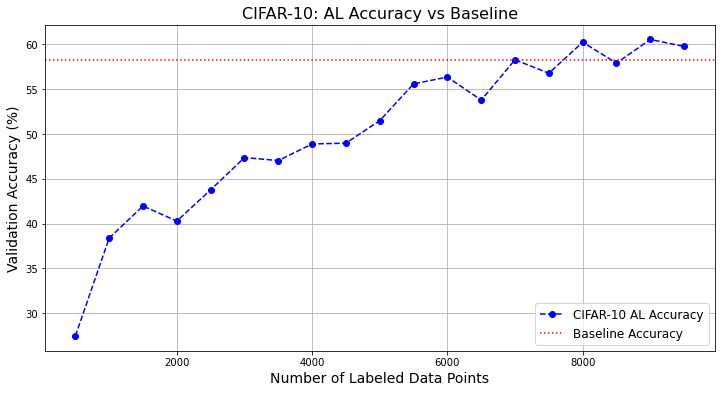

In [80]:
import torch
import torchvision
import numpy as np
from tqdm import tqdm

# ---- Hyperparameters ----
batch_size = 128  # Larger batch size for faster processing
lr = 0.001  # Learning rate
num_epochs = 10  # Fewer epochs to speed up training
initial_size = 500  # Initial labeled dataset size
max_datapoints = 10000  # Max labeled dataset size
points_per_step = 500  # Points added in each AL iteration

# ---- Dataset Transforms ----
cifar_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# ---- Load CIFAR-10 Dataset ----
cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)
cifar_val = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar_transform)

# ---- DataLoader Helper ----
def get_loader(dataset, batch_size, shuffle=True):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

cifar_val_loader = get_loader(cifar_val, batch_size, shuffle=False)

# ---- Model Initialization ----
def get_model():
    model = torchvision.models.resnet18(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, 10)
    return model

# ---- Training and Validation ----
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    model.to(device)
    for epoch in tqdm(range(num_epochs), desc="Training"):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# ---- Baseline Accuracy ----
def baseline_accuracy(train_set, val_loader, dataset_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = get_model()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    labeled_indices = np.random.choice(len(train_set), dataset_size, replace=False)
    labeled_set = torch.utils.data.Subset(train_set, labeled_indices)
    labeled_loader = get_loader(labeled_set, batch_size)

    return train_and_validate(model, labeled_loader, val_loader, criterion, optimizer, device, num_epochs)

# ---- Active Learning Loop ----
def active_learning_accuracy(train_set, val_loader, initial_size, max_datapoints, points_per_step):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = get_model()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Initialize labeled and unlabeled indices
    labeled_indices = np.random.choice(len(train_set), initial_size, replace=False)
    unlabeled_indices = np.setdiff1d(np.arange(len(train_set)), labeled_indices)

    labeled_set = torch.utils.data.Subset(train_set, labeled_indices)
    labeled_loader = get_loader(labeled_set, batch_size)

    datapoints, accuracies = [], []
    while len(labeled_indices) < max_datapoints:
        # Train and validate
        accuracy = train_and_validate(model, labeled_loader, val_loader, criterion, optimizer, device, num_epochs)
        accuracies.append(accuracy)
        datapoints.append(len(labeled_indices))

        if len(labeled_indices) + points_per_step > max_datapoints:
            points_per_step = max_datapoints - len(labeled_indices)

        # Model evaluation for uncertainty sampling
        model.eval()
        uncertainties = []
        global_indices = []
        with torch.no_grad():
            # Process the entire unlabeled dataset in batches
            unlabeled_loader = get_loader(torch.utils.data.Subset(train_set, unlabeled_indices), batch_size, shuffle=False)
            for batch_idx, (images, _) in enumerate(unlabeled_loader):
                images = images.to(device)
                outputs = model(images).softmax(dim=1)
                max_probs, _ = outputs.max(dim=1)
                uncertainties.extend(1 - max_probs.cpu().numpy())
                global_indices.extend(unlabeled_indices[batch_idx * batch_size : batch_idx * batch_size + len(images)])

        # Sort uncertainties and pick the most uncertain samples
        uncertainties = np.array(uncertainties)
        sorted_indices = np.argsort(-uncertainties)
        num_to_add = min(points_per_step, len(global_indices))
        new_indices = np.array(global_indices)[sorted_indices[:num_to_add]]

        # Update labeled and unlabeled indices
        labeled_indices = np.concatenate([labeled_indices, new_indices])
        unlabeled_indices = np.setdiff1d(unlabeled_indices, new_indices)
        labeled_set = torch.utils.data.Subset(train_set, labeled_indices)
        labeled_loader = get_loader(labeled_set, batch_size)

    return datapoints, accuracies

# ---- Run CIFAR-10 Experiments ----
# Baseline Accuracy
cifar_baseline = baseline_accuracy(cifar_train, cifar_val_loader, dataset_size=10000)

# Active Learning Accuracy
cifar_al_datapoints, cifar_al_accuracies = active_learning_accuracy(
    cifar_train, cifar_val_loader, initial_size=initial_size, max_datapoints=max_datapoints, points_per_step=points_per_step
)

# ---- Plot Results ----
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(cifar_al_datapoints, cifar_al_accuracies, label='CIFAR-10 AL Accuracy', linestyle='--', color='blue', marker='o')
plt.axhline(y=cifar_baseline, color='red', linestyle='dotted', label='Baseline Accuracy')
plt.xlabel('Number of Labeled Data Points', fontsize=14)
plt.ylabel('Validation Accuracy (%)', fontsize=14)
plt.title('CIFAR-10: AL Accuracy vs Baseline', fontsize=16)
plt.legend(fontsize=12)
plt.grid()
plt.show()
